# Descrption



More detailed info is in README.md

# 0. Setup

Before using the Spotify API, you'll have to add your credentials. To add them, uncomment the cell below and enter your id and secret in place of (your_id) and (your_secret). 

*Though, it is **not necessary** if you simply want to explore the project: the code will work without them.*

More detailes in part 1.3. 

In [1]:
# !export CLIENT_ID=(your_id)
# !export CLIENT_SECRET=(your_secret)

Installing requirements:

In [2]:
# !pip install -r requirements.txt

Importing key packages:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# 1. Retreiving data

## 1.1. Downloading a Kaggle dataset

We're going to download a Spotify tracks dataset from Kaggle, which contains a lot of the data we need. Most importantly, it contains a collection of different tracks. 

However, at the time of writing, the dataset has been out for 2 years, so the data is not really up to date. However, for the purposes of the project we can ignore this because the methods we use could be applied to any future data.

The dataset may change in the future. If it does, we'd like to use all the most recent data. To do this, we'll make sure we download the data directly.

We will use the **opendatasets** package. This will allow us to retrieve the data directly from Kaggle, which is exactly what we need.

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset")

Skipping, found downloaded files in "./-spotify-tracks-dataset" (use force=True to force download)


Let's store the data in a Pandas data frame.

In [5]:
df = pd.read_csv("-spotify-tracks-dataset/dataset.csv", index_col=0)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


We also want to get updated information about the data when the dataset is updated. 

Let's get the description of the table from the Kaggle page via **selenium**.

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

driver.get("https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset")

A lot of text is hidden - we need to click on the "View more" button. 

However, the cookie bar blocks it, so we accept cookies first and then press "View more".

In [7]:
from selenium.webdriver.common.by import By

# accepting cookies
button = driver.find_element(By.XPATH, "//div[contains(text(),'OK, Got it.')]")
button.click()

# expanding text
button = driver.find_element(By.XPATH, "//span[contains(text(),'View more')]")
button.click()

Now, let's search for the needed text.

In [8]:
lis = driver.find_elements(By.TAG_NAME, "li")
assert len(lis)>0, "No text found"

Finally, the description of each column contains a colon (':'). Let's use this to print the description.

In [9]:
for li in lis:
    if ':' in li.text:
        print(li.text)

track_id: The Spotify ID for the track
artists: The artists' names who performed the track. If there is more than one artist, they are separated by a ;
album_name: The album name in which the track appears
track_name: Name of the track
popularity: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
duration_ms: The track length in milliseconds
explicit: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
danceability: Danceability describes how suitable 

Obviously we are most interested in the **popularity** column - that is our target column. The others are potential features.

Fortunately, most of the columns have numeric values, so we won't have to deal with many categorical features. But we're getting a bit ahead of ourselves: we'll deal with that in the Feature Engineering section.

In [10]:
driver.quit()

## 1.2 First data exploration

Is there any missing data in the table?

In [11]:
df.isna().sum().any()

True

We'll deal with it in next section: as it turns out, this is not an issue.

How many entries are there in the table?

In [12]:
len(df)

114000

However, as we'll se later, a lot of them are duplicates of the same tracks. Let's count how many unique tracks there are, assuming that each unique track corresponds to a unique pair ('artists', 'track_name'):

In [13]:
len(df[['artists', 'track_name']].drop_duplicates())

81344

Let's look at the tracks with minimum popularity.

In [14]:
df[df["popularity"] == min(df["popularity"])][:5]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
23,0BUuuEvNa5T4lMaewyiudB,Jason Mraz,Coffee Moment,93 Million Miles,0,216386,False,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,4,acoustic
24,3Hn3LfhrQOaKihdCibJsTs,Jason Mraz,Human - Best Adult Pop Tunes,Unlonely,0,231266,False,0.796,0.667,5,-4.831,0,0.0392,0.3810,0.000000,0.2210,0.754,97.988,4,acoustic
26,5IfCZDRXZrqZSm8AwE44PG,Jason Mraz,Holly Jolly Christmas,Winter Wonderland,0,131760,False,0.620,0.309,5,-9.209,1,0.0495,0.7880,0.000000,0.1460,0.664,145.363,4,acoustic
27,0dzKBptH2P5j5a0MifBMwM,Jason Mraz,Feeling Good - Adult Pop Favorites,If It Kills Me,0,273653,False,0.633,0.429,4,-6.784,0,0.0381,0.0444,0.000000,0.1320,0.520,143.793,4,acoustic
28,5QAMZTM5cmLg3fHX9ZbTZi,Jason Mraz,Christmas Time,Winter Wonderland,0,131760,False,0.620,0.309,5,-9.209,1,0.0495,0.7880,0.000000,0.1460,0.664,145.363,4,acoustic


How many of them is there?

In [15]:
len(df[df["popularity"] == min(df["popularity"])])

16020

That's a lot, but it's also natural: in the description of the table above (which we got via Selenium), you can see that if the track was popular before, but isn't listened to as much now, it will have a low popularity. 

So, because some tracks lose interest over time, they can reach a popularity of 0. Also, there are many artists who put their music on Spotify but never get any listeners (it's hard to get attention for a new artist).

You may have noticed that tracks in rows 26 and 28 are identical, but are in different albums. These are known as **duplicate tracks**. In many cases these are tracks that were included in a collection, or tracks from albums that ended up with a so-called "deluxe" (extended) version, or singles that were released before the rest of the album as a form of promotion for the upcoming album.

Spotify treats them as different tracks, even though they may be musically identical (or nearly so). Because of this, the tracks will also have independent "popularity" values for each duplicate. 

In the Feature Engineering section, we'll try to keep track of whether the track is a duplicate or not, but we'll also try to get rid of duplicates in the table.

Let's look at tracks with maximum popularity.

In [16]:
df[df["popularity"] == max(df["popularity"])]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,dance
81051,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,pop


Notice a problem: the track we've just found appears twice in the table. The only differences between the 2 records are the row index and the 'track_genre'. So a track can appear more than once in the table simply because it belongs to more than one genre. This has to do with the way the Kaggle dataset was assembled.

Let's see what genres are in the table.

In [17]:
print(f"Sample genres: {random.sample(sorted(set(df['track_genre'])), 5)}.")
print(f"There are {df['track_genre'].nunique()} genres total.")

Sample genres: ['cantopop', 'death-metal', 'piano', 'children', 'happy'].
There are 114 genres total.


Each genre has 1000 entries.

In [18]:
from collections import Counter
assert all(x==1000 for x in Counter(df['track_genre']).values()), "Not all genres have 1000 tracks"

It also appears that the records in the dataset are sorted by the track_genre column.

Later we'll do some feature engineering and try to encode each genre, then we'll also try to encode the track_genre parameter for each track, effectively removing duplicates from the table.

To complete our first exploration of the data, let's look at how the 'artist' data is stored. The artists on the track are listed in a string, separated by a semicolon (';'). This allows us to find the artist in the table:

In [19]:
[artists for artists in df['artists'] if 'Fred again..' in str(artists).split(';')]

['FKA twigs;Headie One;Fred again..']

This means that some artists are only present as co-authors on some tracks. In the next subsection, we'll discuss how the list of artists on a track can be used as predictive metadata.

## 1.3. Adding our data

The "artists" column itself is not very informative. But let's say a new track is released. What does the list of artists on the track tell you about its potential popularity? If you see someone popular on the list, like Taylor Swift, you'll know that the track is likely to be very popular. Similarly, if you don't recognise anyone on the track, it could mean that the track is less likely to be popular. On the other hand, if there are several artists with decent popularity and their audiences don't overlap too much, the track could be particularly popular because their combined audience is quite large.

At this point it should be obvious that we need to know the popularity of each artist. Unfortunately, this information is not available in the original table. However, there is a [Spotify API](https://developer.spotify.com/documentation/web-api) that we can use to get this data. This is what the author of the Kaggle table used to get their data.

The first step in using the API is to get the access token. The process is a bit complicated, so I decided to use the code from a [YouTube video](https://www.youtube.com/watch?v=WAmEZBEeNmg). You can also find the link in the code comments below.

Of course, if you want to use this API as well, you will need to <ins>create a Spotify account</ins> (VPN is required for this, but not needed later in the process). The next steps are also shown in the video.

In [20]:
### FROM https://www.youtube.com/watch?v=WAmEZBEeNmg
from dotenv import load_dotenv
import os
import base64
from requests import post, get
import json

load_dotenv()

client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

def get_token() -> str:
    """Queries the user's token."""
    auth_string = client_id + ':' + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " +  auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result['access_token']
    return token

def get_auth_header(token: str=None) -> dict:
    """Creates header via a token."""
    if token is None:
        token = get_token()
    return {"Authorization": "Bearer " + token}
### END FROM

Let's make query function that find the tracks' or artists' metadata by their id. The algorithm is standard for REST API. 

More details: https://developer.spotify.com/documentation/web-api/reference/get-several-tracks.

In [21]:
from typing import Iterable
def query_by_ids(ids: Iterable[str], type: str, token: str=None) -> list[dict]:
    """Queries the metadata of the tracks or artists by their ids from the Spotify API.

    Args:
        ids (Iterable[str]): A list of track_ids or artist_ids.
        type (str): 'tracks' or 'artists', defines what the ids refer to.
        token (str, optional): The token string; if None is passed, new token is generated. Defaults to None.

    Returns:
        list[dict]: A list of dicts, each dict contains metadata of certain 'type'.
    """
    assert type in ('tracks', 'artists'), "Type has to be either 'tracks' or 'artists'." 
    
    if token is None:
        token = get_token()
    
    url = "https://api.spotify.com/v1/" + type # more info in the docs
    headers = get_auth_header(token)
    query = f"?ids={','.join(ids)}"
    
    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)[type]
    return json_result

The next cell can be used to find the updated data for the table. Popularity for both tracks and artists changes over the time. So, at the time of you reading this the data I found might have changed. You may run the cell, but it will take a long time (15+ minutes). Repeated run of the cell also leads to the Spotify account 24 hour ban due to exceeding the rate limit. That is why I saved all the necessary data in the csv files, which we download next.

*(To run, uncomment cell by selecting all code and pressing Ctrl+/ (or Cmd+/ on Mac). Long runtime!)*

In [22]:
# from tqdm.notebook import trange # progress bar

# # updated data of tracks
# updated_pop = pd.DataFrame(columns=['track_id', 'artist_ids', 'updated_pop']) 
# ids_to_names = {} # what artist each id corresponds to
# markets = set() # where these tracks are available

# sorted_track_ids = sorted(set(df['track_id'])) # unique track ids

# # generate token
# token = get_token()

# # split data in batches: there is a limit on ids in Spotify API query
# for batch_start in trange(0, len(sorted_track_ids), 50):
#     # query tracks' metadata by their ids in batch
#     tracks_metadata = query_by_ids(
#         sorted_track_ids[batch_start:min(batch_start+50, len(sorted_track_ids))], 
#         type='tracks', token=token)
    
#     # decompose each track's metadata into useful information    
#     for i, track_metadata in enumerate(tracks_metadata):
#         # data to append to updated_pop dataframe
#         artists_on_track = []
#         # add artist_id for each artist on track
#         for artist_data in track_metadata['artists']:
#             ids_to_names[artist_data['id']] = artist_data['name']
#             artists_on_track.append(artist_data['id'])
            
#         # add track's up-to-date data    
#         updated_pop.loc[batch_start+i, :] = (
#             sorted_track_ids[batch_start+i], # id
#             ';'.join(artists_on_track), # artist ids, sep=';'
#             track_metadata['popularity']) # updated popularity
        
#         # add markets where this track is available
#         markets = markets.union(track_metadata['available_markets'])

# # convert set to sorted list        
# markets = sorted(markets)

# # save data into csv files     
# updated_pop.to_csv('data/updated_pop.csv', index=False, header=True)
# pd.Series(markets).to_csv('data/markets.csv', index=False, header=False)

# artists_popularity = {} # what popularity each artist has

# # refresh token
# token = get_token()
# artist_ids = sorted(ids_to_names.keys())

# # again, splitting in batches
# for batch_start in trange(0, len(artist_ids), 50):
#     # query artists' metadata by their ids in batch
#     artists_metadata = query_by_ids(
#         artist_ids[batch_start:min(batch_start+50, len(artist_ids))],
#         type='artists', token=token)
    
#     # add each artist's popularity
#     for artist_metadata in artists_metadata:
#         artists_popularity[artist_metadata['id']] = artist_metadata['popularity']

# # save data into csv file: artist ids, names and popularity        
# pd.concat([pd.Series(ids_to_names).sort_index(),
#            pd.Series(artists_popularity)], axis=1
#           ).reset_index().to_csv('data/artists_popularity.csv', index=False, header=['artist_id', 'name', 'popularity'])

You might get 'JSONDecodeError' several times. Worst case scenario is that you are blocked for exceeding the rate limit of API. To check this, run the cell below.

In [23]:
from json import JSONDecodeError
def check_rate_limit():
    """Checks if your account is blocked for exceeding the rate limit.
    """
    token = get_token()
    url = "https://api.spotify.com/v1/tracks"
    headers = get_auth_header(token)
    query = f"?ids={df['track_id'][0]}"
    
    query_url = url + query
    result = get(query_url, headers=headers)
    try:
        json.loads(result.content)
        print('No block!')
    except JSONDecodeError:
        retry_after = int(result.headers['retry-after'])
        print(f'You are blocked! Try again in {retry_after} seconds ({retry_after/3600} hours).')

In [24]:
# check_rate_limit()

If you got the error, but there is no block, just rerun the cell! There might've been a problem from the Spotify server's side.

Now, let's read the csv files we got:

In [25]:
updated_pop = pd.read_csv('data/updated_pop.csv')
updated_pop.head()

,track_id,artist_ids,updated_pop
0,0000vdREvCVMxbQTkS888c,2C9gfZqYe1UrhZP3ADjIm9,28
1,000CC8EParg64OmTxVnZ0p,0SCbttzoZTnLFebDYmAWCm,46
2,000Iz0K615UepwSJ5z2RE5,0rasA5Z5h1ITtHelCpfu9R;04jj7dljPI0ixtNsz2pXWK,0
3,000RDCYioLteXcutOjeweY,3TozxPbDes76aGFdfv7PMv;4eHycMGKslAXJLcLO4F82x,58
4,000qpdoc97IMTBvF8gwcpy,0rasA5Z5h1ITtHelCpfu9R,16


In [26]:
artists_popularity = pd.read_csv('data/artists_popularity.csv')
artists_popularity.head()

,artist_id,name,popularity
0,001aJOc7CSQVo3XzoLG4DK,One Way,42
1,001bpbe3Erwxc1cVfgVuFo,Padre Adriano Zandoná,25
2,002yVW3Yn595KWy74buQ1k,Charanraj MR,49
3,003RCo7NufjcwyuXRTWlGM,Solace Her,23
4,003f4bk13c6Q3gAUXv7dGJ,Wiener Philharmoniker,65


In [106]:
markets = list(pd.read_csv('data/markets.csv', header=None)[0])
random.sample(markets, 5)

['AO', 'XK', 'PA', 'WS', 'AD']

Let's add the updated popularity and artist_ids to the initial dataframe.

In [28]:
df_ext = pd.merge(df, updated_pop, on='track_id')

# 2. Feature engineering

We have some useful nonnumeric (categorical) data in the table. We'd like to convert it into numeric values, because it would be easier to work with. This is what I mean by **feature engineering**. But we have to do it in a smart way.

In [29]:
df_ext.head(10)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_ids,updated_pop
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1S2S00lgLYLGHWA44qGEUs,64
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,142VT1MtWzaD13CnOiKFDn,45
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,2vm8GdHyrJh2O2MfbQFYG0;5ZsFI1h6hIdQRw2ti0hz81,50
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,7h4j9YTJJuAHzLCc3KCvYu,67
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,5D3muNJhYYunbRkh3FKgX0,78
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,6,...,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic,5zeCSgiRyezbfLiGOpKAsR,0
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic,5xKp3UyavIBUsGy3DQdXeF;1l7ZsJRRS8wlW3WfJfPfNS,70
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic,4phGZZrJZRo4ElhRtViYdl,77
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,0,...,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic,4phGZZrJZRo4ElhRtViYdl;6aZyMrc4doVtZyKNilOmwu,68
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,1,...,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic,5nHR37FDSU4I0QQta0AZ1C,54


For the purposes of this project, we won't be doing any NLP (natural language processing). Rather than delving into DL methods, we'll stick to classical statistical and ML methods. However, this is a good option for future work. 

We can use **target encoding** on the track_genre column. This simply means that we replace the genre name with the average popularity of tracks in that genre. 

Let's find the average popularity of each genre.

In [30]:
df_ext.groupby('track_genre')['popularity'].mean()

track_genre
acoustic       42.483
afrobeat       24.399
alt-rock       33.943
alternative    24.337
ambient        44.191
                ...  
techno         39.042
trance         37.635
trip-hop       34.460
turkish        40.698
world-music    41.873
Name: popularity, Length: 114, dtype: float64

There is a useful method *transform* in pandas which will allow us to put these values into our table:

In [31]:
df_ext.groupby('track_genre')['popularity'].transform('mean')

0         42.483
1         42.483
2         42.483
3         42.483
4         42.483
           ...  
113995    41.873
113996    41.873
113997    41.873
113998    41.873
113999    41.873
Name: popularity, Length: 114000, dtype: float64

We could just add this as another column. But there are 3 problems with that:
- We will run into **target leakage** (https://en.wikipedia.org/wiki/Leakage_(machine_learning)). In simple words, we want to estimate our prediction on so-called *test* data, so some rows should be treated as if they don't exist (as if we only get this data when we deploy the model, and we don't know the 'popularity' value for it), but our target encoding uses all the data in the table, which means that the data we should forget about for now will somehow *leak* into our features. 
- There are duplicates of tracks with multiple genres. We want to get rid of the duplicates now, because to avoid target leakage we will not encode until after we have split the data into train and test, when it may be too late to get rid of the duplicates.
- We would also like to be able to do target encoding with 'updated pop' as another target.

First, we combine all genres of tracks into one cell:

In [32]:
df_ext['track_genre'] = df_ext.groupby('track_id')['track_genre'].transform(lambda x: ';'.join(x))
df_ext = df_ext.drop_duplicates().reset_index(drop=True)
df_ext

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_ids,updated_pop
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic;j-pop;singer-songwriter;songwriter,1S2S00lgLYLGHWA44qGEUs,64
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic;chill,142VT1MtWzaD13CnOiKFDn,45
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,2vm8GdHyrJh2O2MfbQFYG0;5ZsFI1h6hIdQRw2ti0hz81,50
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,7h4j9YTJJuAHzLCc3KCvYu,67
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,5D3muNJhYYunbRkh3FKgX0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90456,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,...,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,3IygNfufoCZx61wd14t19E,0
90457,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,...,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,3IygNfufoCZx61wd14t19E,0
90458,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,...,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,0Nks3cFWU2a7rooAlFQYgn,28
90459,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,...,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,5aBxFPaaGk9204ssHUvXWN,37


However, there are still duplicate tracks that I've talked about before: those that have the same name and artists (and everything else), but are on different albums:

In [33]:
len(df_ext) == len(df_ext[['artist_ids', 'track_name']].drop_duplicates())

False

Let's get rid of the duplicates, but keep the information about whether the track has a duplicate. Before that, however, we finally have to get rid of NaN by replacing it with ''.

In [34]:
df_ext = df_ext.fillna('')

In [35]:
df_ext['is_duplicate'] = df_ext.groupby(['artist_ids', 'track_name'])['track_id'].transform(lambda x: x.nunique() > 1)
df_ext.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_ids,updated_pop,is_duplicate
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic;j-pop;singer-songwriter;songwriter,1S2S00lgLYLGHWA44qGEUs,64,False
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic;chill,142VT1MtWzaD13CnOiKFDn,45,False
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,2vm8GdHyrJh2O2MfbQFYG0;5ZsFI1h6hIdQRw2ti0hz81,50,False
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,7h4j9YTJJuAHzLCc3KCvYu,67,True
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,5D3muNJhYYunbRkh3FKgX0,78,True


Because duplicate tracks have independent popularity, let's take the maximum of popularities. Then we simply leave only the first of the duplicates in the table.

In [36]:
df_ext['popularity'] = df_ext.groupby(['artist_ids', 'track_name'])['popularity'].transform('max')
df_ext['updated_pop'] = df_ext.groupby(['artist_ids', 'track_name'])['updated_pop'].transform('max')
df_ext = df_ext.drop_duplicates(subset=['artist_ids', 'track_name']).reset_index(drop=True)
df_ext

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,artist_ids,updated_pop,is_duplicate
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic;j-pop;singer-songwriter;songwriter,1S2S00lgLYLGHWA44qGEUs,64,False
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic;chill,142VT1MtWzaD13CnOiKFDn,45,False
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,2vm8GdHyrJh2O2MfbQFYG0;5ZsFI1h6hIdQRw2ti0hz81,50,False
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,7h4j9YTJJuAHzLCc3KCvYu,67,True
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,5D3muNJhYYunbRkh3FKgX0,78,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81366,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,...,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,3IygNfufoCZx61wd14t19E,0,False
81367,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,...,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,3IygNfufoCZx61wd14t19E,0,False
81368,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,...,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,0Nks3cFWU2a7rooAlFQYgn,28,False
81369,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,...,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,5aBxFPaaGk9204ssHUvXWN,37,False


Let's save this dataset for further use in the Streamlit app.

In [148]:
df_ext.to_csv('data/df_ext.csv')

Now we can do target encoding. To do this, I've created a class:

In [37]:
class TargetEncoder:
    """Does target encoding for categorical features with several categories in one row.
    """    
    def fit(self, data: pd.DataFrame, categorical_feature: str, target: str, cat_sep: str=';') -> None:
        """Creates target encoding based on passed data, even if there are several categories for each row.

        Args:
            data (pd.DataFrame): DataFrame from which to take the data for calculating encoding.
            cateorical_feature (str): The column you want to encode.
            target (str): The target column, based on which the target encoding is done.
            cat_sep (str, optional): Separator of categories in a 'cateorical_feature' cell. Defaults to ';'.
        """
        # remember target values for each category        
        category_targets = {}
        for i, categories in enumerate(data[categorical_feature].transform(lambda x: x.split(cat_sep))):
            for category in categories:
                if category not in category_targets.keys():
                    category_targets[category] = [data[target][i]]
                else:
                    category_targets[category].append(data[target][i])
        # each category is encoded with mean target value
        self.encoding = {category: np.mean(targets) for category, targets in category_targets.items()}
        # what to substitute the unknown category with: average target value            
        self.default = data[target].mean()
        
    def encode_cell(self, categories: str, cat_sep: str=';') -> np.float64:
        """Encodes a category cell.

        Args:
            categories (str): The cell you want to encode.
            cat_sep (str, optional): Separator of categories in a 'cateorical_feature' cell. Defaults to ';'.

        Returns:
            np.float64: Mean of target encodings of categories in cell.
        """
        return np.mean(list(map(
            lambda x: self.encoding.get(x, self.default), # encode each category; if not encoded, defaults to self.na
            categories.split(cat_sep)))) # separates categories in cell
        
    def transform(self, data: pd.DataFrame, categorical_feature: str) -> pd.Series:
        """Applies encoding. Unknown values are replaced with average target value from train data.

        Args:
            data (pd.DataFrame): DataFrame from which to take the data to encode.
            cateorical_feature (str): The column you want to encode.

        Returns:
            pd.Series:  The new column of your DataFrame with target encoded categorical feature.
        """
        return data[categorical_feature].transform(self.encode_cell)
        
    def fit_transform(self, data: pd.DataFrame, categorical_feature: str, target: str, cat_sep: str=';') -> pd.Series:
        """Fits the encoder and transforms the given data at once.

        Args:
            data (pd.DataFrame): DataFrame from which to take the data for calculating encoding.
            cateorical_feature (str): The column you want to encode.
            target (str): The target column, based on which the target encoding is done.

        Returns:
            pd.Series: The new column of your DataFrame with target encoded categorical feature.
        """
        self.fit(data, categorical_feature, target, cat_sep)
        return self.transform(data, categorical_feature)

This is how the encoding of the track's genres looks like:

In [38]:
enc = TargetEncoder()
enc.fit_transform(df_ext, 'track_genre', 'popularity')

0        46.203582
1        49.635814
2        43.737513
3        43.737513
4        43.737513
           ...    
81366    41.939331
81367    41.939331
81368    41.939331
81369    41.939331
81370    41.939331
Name: track_genre, Length: 81371, dtype: float64

We are ready to assemble a **data preparation** pipeline:
1. We want to be able to look at the initial (train) data and use it to:
- Find average 'popularity' and 'updated_pop' over the table;
- Find these values for each genre separately;
- Create a target encoder for genres based on that;

- In other words, we want to apply the **TargetEncoder** above.

2. We also want to replace the artists on a track with:
- A number of artists on track;
- A mean popularity of artists on the track;
- The maximum popularity of the artists;
- For simplicity, we'll make a dictionary with 'artist_id' as a key and an updated popularity as value (from data/artists_popularity.csv).

3. <ins>BUT</ins> if we use the data on the artist's popularity, we cannot use as the target the popularity that was initially in the table, but the updated popularity that we retreived via Spotify API. So, we make 2 pairs of data: one in which we'd like to use the original data on the tracks' popularity, but we can only encode the artists by their number on track (no reference to the up-to-date popularity), and one in which the target is the updated popularity and we encode artist with their popularity, too.

4. We want to extract only the features we need and separate the targets ('popularity' and 'updated_pop') from the features.

5. After we split the data further on, we'll apply 'fit_transform' on train data and 'transform' on test to prevent any target leakage (we fit only on train).

Here is how I did it:

In [39]:
class DataPrep:
    def __init__(self, to_encode: str='track_genre', target1: str='popularity', target2: str='updated_pop') -> None:
        """Prepares the data for further analysis. Selects data to encode. Makes an artist-populairty dictionary.

        Args:
            to_encode (str): Which column to do target encoding on. Defaults to 'track_genre'.
            target1 (str): The first target for target encoding. Defaults to 'popularity'.
            target2 (str): The second target for target encoding. Defaults to 'updated_pop'.
        """
        # target encoders to encode the genres by: 1. popularity, 2. updated_pop
        self.encoder_1 = TargetEncoder()
        self.encoder_2 = TargetEncoder()
        
        # storing genre column, as well as 'popularity' and 'updated_pop' in variables
        self.to_encode = to_encode
        self.target1 = target1
        self.target2 = target2
        
        # we'll use this dictionary for easy encoding of artists' popularity
        self.artists_pop_dict = {}
        for _, row in artists_popularity.iterrows(): # iterrating over data/artists_popularity.csv
            self.artists_pop_dict[row['artist_id']] = row['popularity'] # { (artist): (popularity), }
        
    def fit(self, data: pd.DataFrame) -> None:
        """Does target encoding fitting.

        Args:
            data (pd.DataFrame): Where to take data from.
        """
        # fitting target encoders
        self.encoder_1.fit(data, self.to_encode, self.target1)
        self.encoder_2.fit(data, self.to_encode, self.target2)
        
    def transform(self, data: pd.DataFrame) -> tuple:
        """Does target encoding transformation and separates data to features and targets.

        Args:
            data (pd.DataFrame): Where to take data from.

        Returns:
            tuple: A tuple with the features tables, the first target, and the second target.
        """
        # separating targets
        y1, y2 = data[self.target1], data[self.target2]
        
        # forming the dataset with no reference to up-to-date data
        X1 = data.drop(self.target2, axis=1) # remove 'updated_pop'
        X1[f'{self.to_encode}_{self.target1}'] = self.encoder_1.transform(X1, self.to_encode) # encode genres
        X1['n_artists'] = X1['artist_ids'].str.split(';').transform(len)
        X1 = X1[
            X1.columns[X1.dtypes != np.dtype('O')] # remove all 'object' columns
            ].drop(self.target1, axis=1) # remove targets
        
        
        X2 = data.drop(self.target1, axis=1)
        X2[f'{self.to_encode}_{self.target2}'] = self.encoder_2.transform(X2, self.to_encode)
        X2['n_artists'] = X2['artist_ids'].str.split(';').transform(len)
        X2['mean_artist_pop'] = X2['artist_ids'].str.split(';').transform(lambda x: np.mean([
            self.artists_pop_dict[artist] for artist in x
        ]))
        X2['max_artist_pop'] = X2['artist_ids'].str.split(';').transform(lambda x: max(
            self.artists_pop_dict[artist] for artist in x
        ))        
        X2 = X2[
            X2.columns[X2.dtypes != np.dtype('O')]
            ].drop(self.target2, axis=1)
        
        return X1, y1, X2, y2
    
    def fit_transform(self, data: pd.DataFrame) -> tuple:
        """Fits and transforms the data.

        Args:
            data (pd.DataFrame): Where to take data from.

        Returns:
            tuple: A tuple with the features table, the first target, and the second target.
        """
        self.fit(data)
        return self.transform(data)

In [40]:
data_prep = DataPrep()
data_prep.fit_transform(df_ext)[0].head()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,is_duplicate,track_genre_popularity,n_artists
0,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,False,46.203582,1
1,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,False,49.635814,1
2,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,False,43.737513,2
3,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,True,43.737513,1
4,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,True,43.737513,1


In [41]:
data_prep.transform(df_ext)[1].head()

0    73
1    55
2    57
3    71
4    82
Name: popularity, dtype: int64

In [42]:
data_prep.transform(df_ext)[2].head()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,is_duplicate,track_genre_updated_pop,n_artists,mean_artist_pop,max_artist_pop
0,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,False,37.536358,1,59.0,59
1,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,False,35.951864,1,43.0,43
2,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,False,35.100956,2,65.0,75
3,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,True,35.100956,1,57.0,57
4,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,True,35.100956,1,60.0,60


In [43]:
data_prep.transform(df_ext)[3].head()

0    64
1    45
2    50
3    67
4    78
Name: updated_pop, dtype: int64

# 3. Visualization

## 3.1 Geodata

We created the data/markets.csv file for a specific reason: Spotify isn't used everywhere in the world, so I want to visualise where the tracks in the dataset can be listened to.

In [107]:
random.sample(markets, 5)

['TO', 'MO', 'GN', 'PR', 'MC']

Further on we will have to use 3 letter codes instead of 2 letter ones. So, we make a dictionary via pycountry:

In [142]:
import pycountry

country_codes_dict = {}
for country in pycountry.countries:
    country_codes_dict[country.alpha_2] = country.alpha_3

In [143]:
markets_3_codes = []
for code in markets:
    if code in country_codes_dict.keys():
        markets_3_codes.append(country_codes_dict[code])
random.sample(markets_3_codes, 5)

['VNM', 'MYS', 'LSO', 'MHL', 'SVN']

Some codes may have been missed because pycountry doesn't recognise some countries as independent, although we will see them on the map later (e.g. Kosovo).

Next, we'll use folium for the map visualisation and the data/world-countries.json file for the country geometry:

In [146]:
import folium

# Create a map object
m = folium.Map(location=[0, 0], zoom_start=2)

# Add a GeoJSON layer to highlight the countries
folium.GeoJson(
    data=open('data/world-countries.json', 'r', encoding='utf-8-sig').read(),
    style_function=lambda feature: {
        'fillColor': 'green' if feature['id'] in markets_3_codes else 'gray',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.5,
    }
).add_to(m)

m.save('data/markets.html')

In [147]:
m

As we can see, most of the countries are highlighted, but some important countries (Russia, China, etc.) are not. 

This means that the results may not be generally applicable: if the way popularity is formed in the highlighted countries is different from the way it happens in the unhighlighted countries, our results may not be useful. Not to mention the fact that not everyone in the highlighted countries uses Spotify!

So while our analysis has some limitations, it is still interesting.

## 3.2 Targets (popularity 2 years ago vs today)

For visualization, we don't care about leakage. Let's simply extract the necessary data via DataPrep we've just built:

In [44]:
data_prep = DataPrep()
X_pop, y_pop, X_upd, y_upd = data_prep.fit_transform(df_ext)

First, let's look at the distribution of the targets:

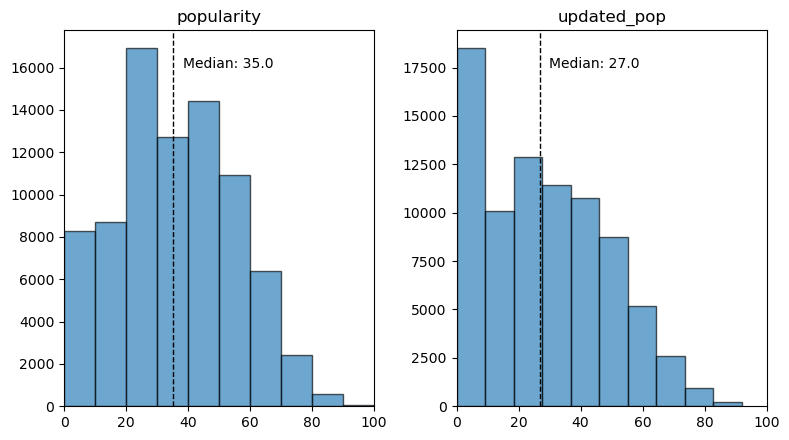

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2) # 2 plots in 1

# making histograms with a dashed meadian line for each
ax1.hist(y_pop, edgecolor='k', alpha=0.65)
ax1.set_xlim(0, 100)
ax1.axvline(y_pop.median(), color='k', linestyle='dashed', linewidth=1)
_, max_ylim = ax1.get_ylim()
ax1.text(y_pop.median()*1.1, max_ylim*0.9, f'Median: {y_pop.median()}')
ax1.set_title(y_pop.name)

ax2.hist(y_upd, edgecolor='k', alpha=0.65)
ax2.set_xlim(0, 100)
ax2.axvline(y_upd.median(), color='k', linestyle='dashed', linewidth=1)
_, max_ylim = ax2.get_ylim()
ax2.text(y_upd.median()*1.1, max_ylim*0.9, f'Median: {y_upd.median()}')
ax2.set_title(y_upd.name)

fig.set_size_inches(8, 4.5)
plt.tight_layout()
plt.show()

As we can see, on average, tracks' popularity has dropped (the original data was retreived 2 years ago). There is also much more tracks that have minimum popularity now than it used to be. This demonstrates well that the targets' values are very different.

It's interesting how exactly the tracks' popularity changed:

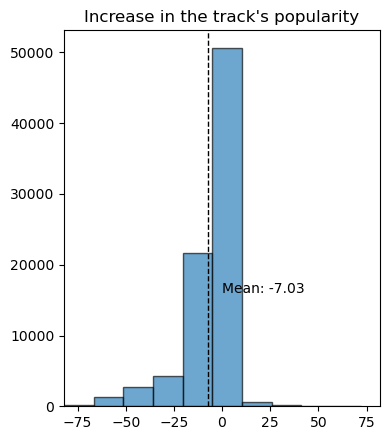

In [46]:
fig, ax = plt.subplots()

plt.hist(y_upd-y_pop, edgecolor='k', alpha=0.65)
lim = np.max(np.abs(y_upd-y_pop))
ax.set_xlim(-lim, lim)
ax.axvline((y_upd-y_pop).mean(), color='k', linestyle='dashed', linewidth=1)
_, max_ylim = ax1.get_ylim()
ax.text(0, max_ylim*0.9, f'Mean: {round((y_upd-y_pop).mean(), 2)}')
ax.set_title("Increase in the track's popularity")

fig.set_size_inches(4, 4.5)
plt.tight_layout()
plt.show()

So, the tracks either didn't change in popularit, or they grew a bit, or they dropped quite significantly. I think there is a pretty natural explanation for this:
- If the track had 0 listeners before, it still won't have any (*explains how centered the distribution is*);
- If the track was popular due to being 'fresh', its popularity should have faded a bit (*explains the left tail*);
- If the track had already been popular for a while, it still should be as popular or even more than before (*explains the offset of the center to the right*);
- Some tracks might've gained a little more popularity over time as the artists' audience grew, and the new fans started listening to the old tracks of that (*explains the right tail*).

## 3.3 Correlation between features and targets

Let's try to understand how the features correlate with each other and with the target. We could use sns.pairplot:

```python
sns.pairplot(pd.concat((X_pop, y_pop), axis=1))
plt.show()
```

It shows histograms for each feature and the target on the diagonal and a co-plot for 2 series off the diagonal.

However, it is really hard to see anything (because there are so many features) and the plots are not really informative. Instead, let's look at a correlation table that we can create using this function:

In [47]:
from matplotlib.colors import LinearSegmentedColormap

def corr_plot(data: pd.DataFrame, title: str, size: tuple[int]=(11, 11)) -> None:
    """Builds a Red-White-Green heatmap of the passed data.

    Args:
        data (pd.DataFrame): Data to visualize the self-correleation of.
        title (str): The title of the plot
        size (tuple[int]): The width and height of the plot. Defaults to (11, 11).
    """
    # color scale
    red_white_green = LinearSegmentedColormap.from_list('RdWtGn', [(0, '#FF0000'), (0.5, '#FFFFFF'), (1, '#00FF00')])
    
    # set shape and size of plot
    plt.gca().set_aspect('equal')
    plt.gcf().set_size_inches(*size)
    
    # find correlations
    correlation = np.round(np.corrcoef(np.float64(data), rowvar=False), 2)
    
    # heatmap
    sns.heatmap(correlation, cmap=red_white_green, vmin=-1, vmax=1,
                xticklabels=data.columns, yticklabels=data.columns, annot=True)
    
    # title and beauty
    plt.title(title, fontsize=25)
    plt.tight_layout()
    plt.show()

Applying to the initial data:

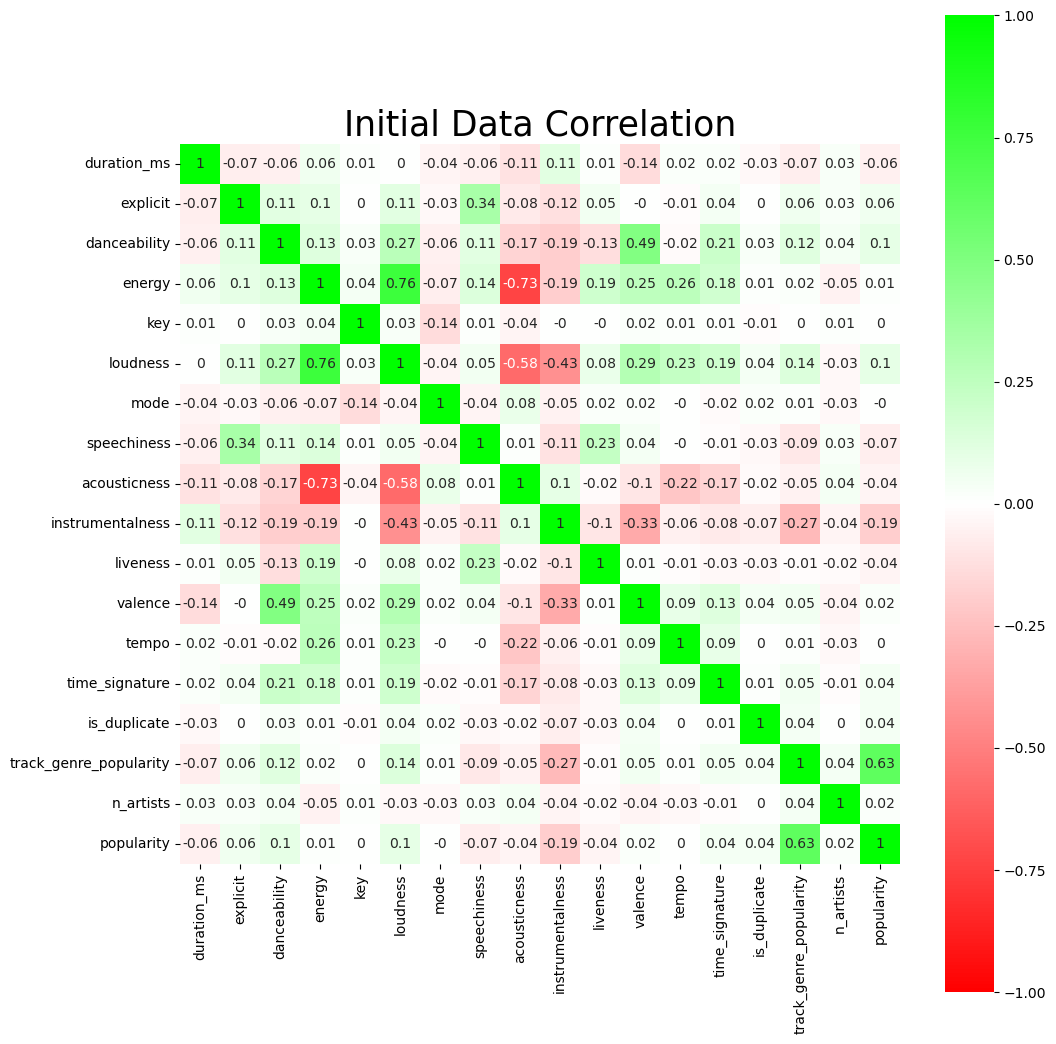

In [48]:
corr_plot(pd.concat((X_pop, y_pop), axis=1), title='Initial Data Correlation')

Applying to the updated data:

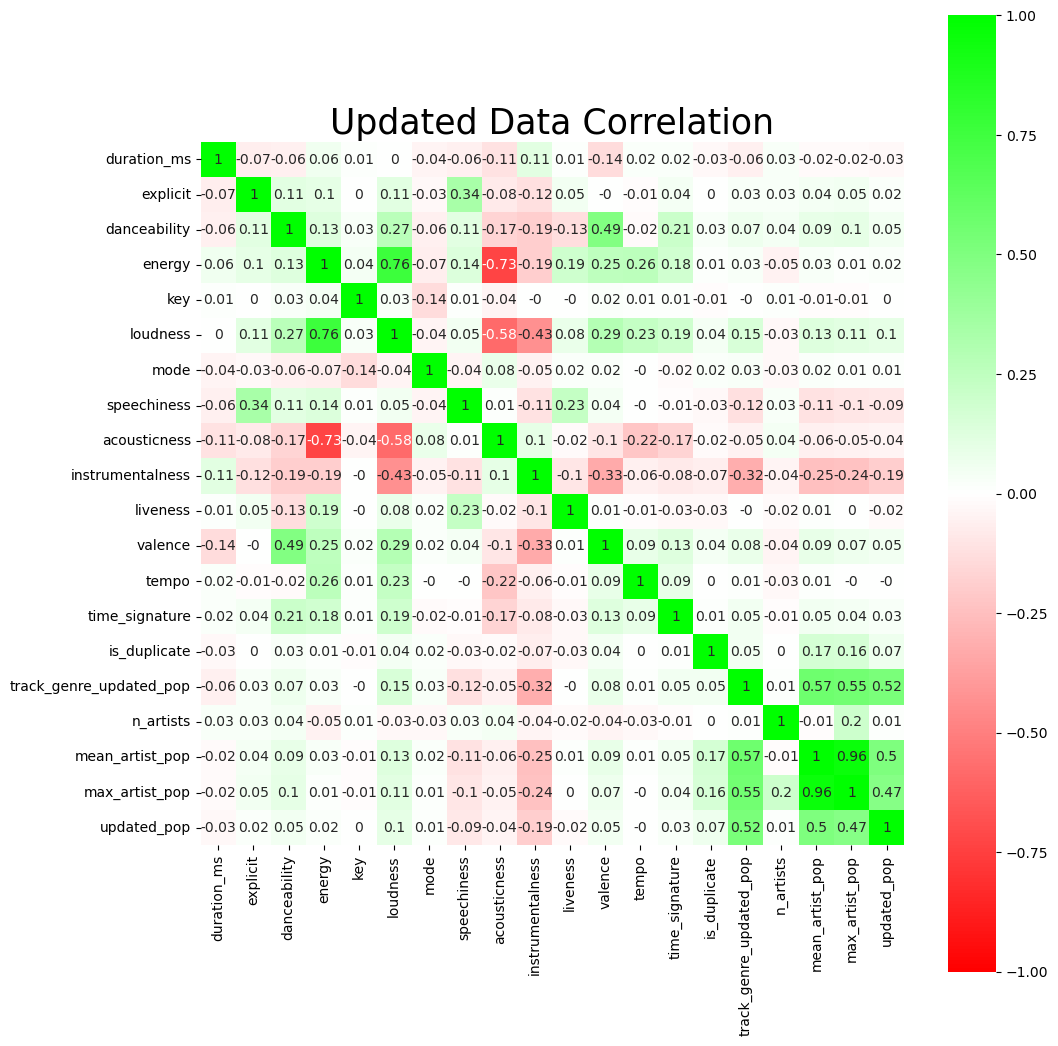

In [49]:
corr_plot(pd.concat((X_upd, y_upd), axis=1), title='Updated Data Correlation')

For us, the most interesting data is in the last row of both heatmaps. As we can see:
- The <ins>genre popularity</ins> is the *only* significant feature in the original data. Unfortunately, this is due to leakage, which we'll try to get rid of in the next section.
- What is interesting, however, is that <ins>instrumentallness</ins> is negatively correlated with both popularity and updated_pop. This tells us that having no vocals on the track is a bad idea if you want to make a hit.
- As expected, the popularity of the artist (both mean and max) has a high correlation with the popularity of the updated track.

Otherwise we see that it is almost **impossible** to predict popularity.

About the data in general:
- The correlation between popularity and features is almost the same as between updated_pop and features, although popularity has changed a lot.
- There is a high correlation between some tags:
1. The more energetic the track, the louder it is.
2. The more energetic the track, the less acoustic it is.
3. The more acoustic the track, the less loud it is.
4. The more danceable the track, the happier it is (the higher the valence)
5. The more instrumental the track, the less loud it is
- Explicitness, key, mode and tempo seem to be the least informative features.

# 4. Feature importance

## 4.1 Univariate feature selection

This part is partly based on the Sklearn article ["Feature Selection"](https://scikit-learn.org/stable/modules/feature_selection.html). 

**Univariate feature selection** works by selecting the best features based on univariate statistical tests. More specifically, it performs a statistical test (f-test, or Fisher test, by default) on each of the features separately to identify the scores for each feature:

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

k = 8

selector = SelectKBest(f_regression, k=k).fit(X_pop, y_pop)
for feature, score in list(zip(X_upd.columns, selector.scores_)):
    print(feature, score)

duration_ms 255.13045362691176
explicit 345.14377584822097
danceability 747.5890117258572
energy 3.9296660748178662
key 1.0074917886504366
loudness 858.5854196949919
mode 1.5987124624125923
speechiness 396.2609408612633
acousticness 149.64221798794986
instrumentalness 2962.1799638274842
liveness 104.07157187590323
valence 35.06537864312963
tempo 0.09236482773174988
time_signature 148.4810882351845
is_duplicate 128.5245023751399
track_genre_updated_pop 54573.749688978714
n_artists 34.00218638142246


Let's visualize the f-scores of the test:

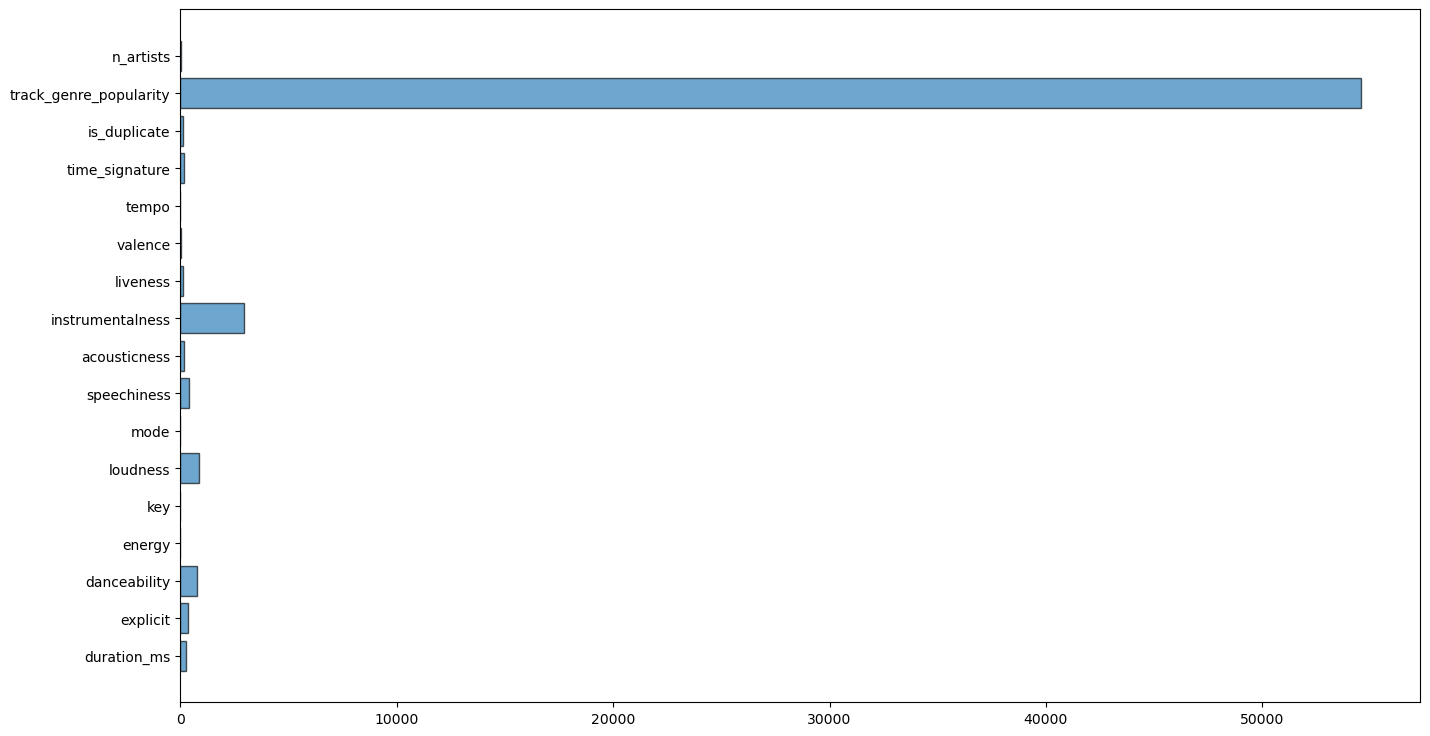

In [51]:
plt.barh(X_pop.columns, selector.scores_, edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

The top 8 features, according to the f-test, are:

In [52]:
selector.get_feature_names_out()

array(['duration_ms', 'explicit', 'danceability', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness',
       'track_genre_popularity'], dtype=object)

Now, the same for the updated data:

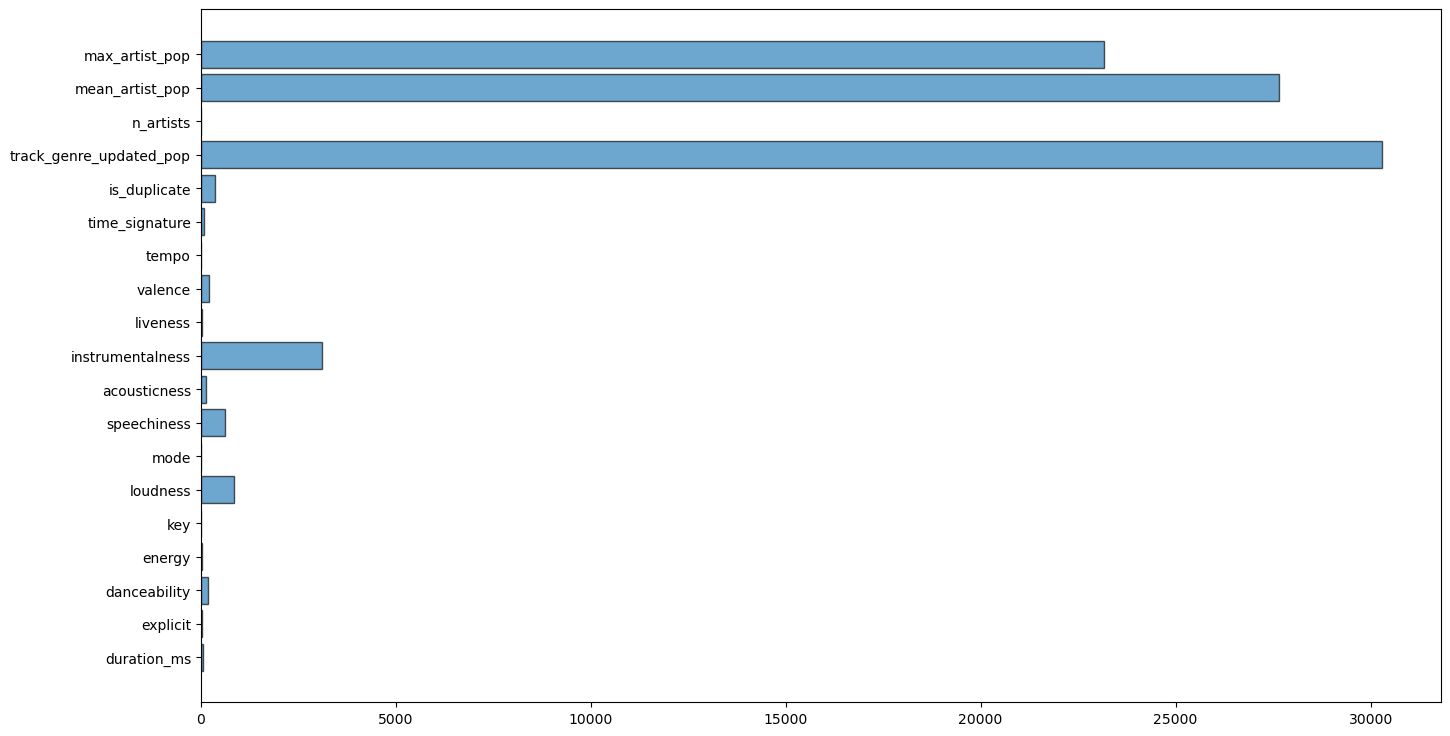

In [53]:
selector = SelectKBest(f_regression, k=k).fit(X_upd, y_upd)
plt.barh(X_upd.columns, selector.scores_, edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

In [54]:
selector.get_feature_names_out()

array(['loudness', 'speechiness', 'instrumentalness', 'valence',
       'is_duplicate', 'track_genre_updated_pop', 'mean_artist_pop',
       'max_artist_pop'], dtype=object)

**BUT**: we often normalize data before using it for machine learning. How will the test results change if we first normalize the data? (Testing only on the updated data: as we have seen, this is fairly sufficient.)

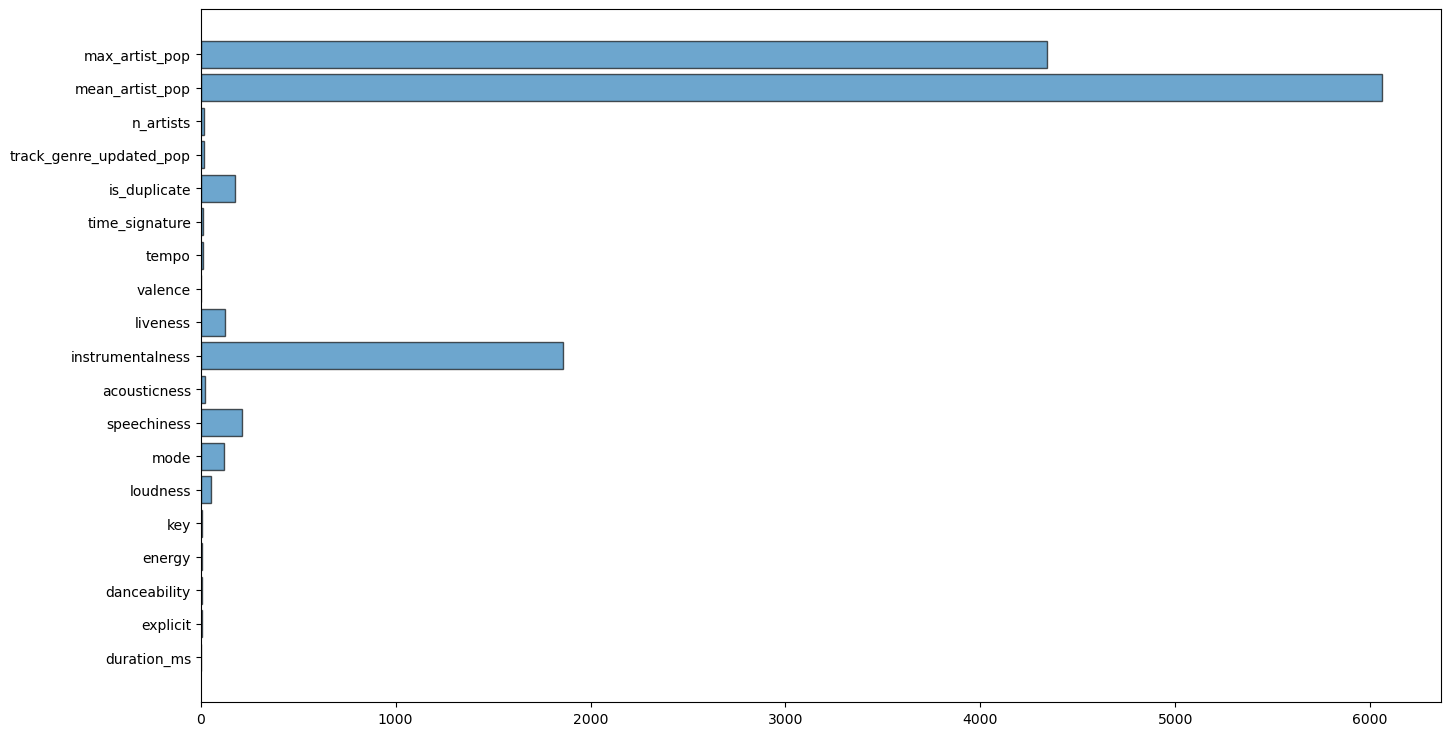

In [55]:
from sklearn.preprocessing import Normalizer

# normalizing
norm = Normalizer()
X_upd_norm = norm.fit_transform(X_upd)
X_upd_norm = pd.DataFrame(data=X_upd_norm, columns=X_upd.columns) # converting back to a dataframe

selector = SelectKBest(f_regression, k=k).fit(X_upd_norm, y_upd)
plt.barh(X_upd.columns, selector.scores_, edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

In [56]:
selector.get_feature_names_out()

array(['loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
       'is_duplicate', 'mean_artist_pop', 'max_artist_pop'], dtype=object)

Significantly different results! 
- mean_artist_pop and max_artist_pop are still very important. 
- is_duplicate, instrumentality and speechiness have become more important. 
- Loudness is still important, but the relative value has decreased. 
- Out of nowhere, track_genre_updated_pop is no longer important! Neither is valence, but now mode and liveness are considered informative (more so than loudness).

This should teach us that we cannot blindly believe just one of the feature importance tests, and that we need to do more research into which features are important.

## 4.2 Linear regression weights

On an ML course we learn that the weights of linear regression, *if the data was normalized before learning*, represents the importance of a feature.

Let's split the data, use the DataPrep to encode data, normalize it and use linear regression for learning.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

# train-test split
data_train, data_test = train_test_split(df_ext, test_size=0.2, random_state=42)
data_train, data_test = data_train.reset_index(drop=True), data_test.reset_index(drop=True)

# encoding categorical data
data_prep = DataPrep()
X_pop_train, y_pop_train, X_upd_train, y_upd_train = data_prep.fit_transform(data_train)
X_pop_test, y_pop_test, X_upd_test, y_upd_test = data_prep.transform(data_test) # ! don't fit !

# normalization
norm_pop, norm_upd = Normalizer(), Normalizer()
X_pop_train = pd.DataFrame(data=norm_pop.fit_transform(X_pop_train), columns=X_pop_train.columns)
X_upd_train = pd.DataFrame(data=norm_upd.fit_transform(X_upd_train), columns=X_upd_train.columns)
X_pop_test = pd.DataFrame(data=norm_pop.transform(X_pop_test), columns=X_pop_test.columns) # ! don't fit !
X_upd_test = pd.DataFrame(data=norm_upd.transform(X_upd_test), columns=X_upd_test.columns) # ! don't fit !

Applying linear regression to original data and visualizing the absolute size of the weights for each feature:

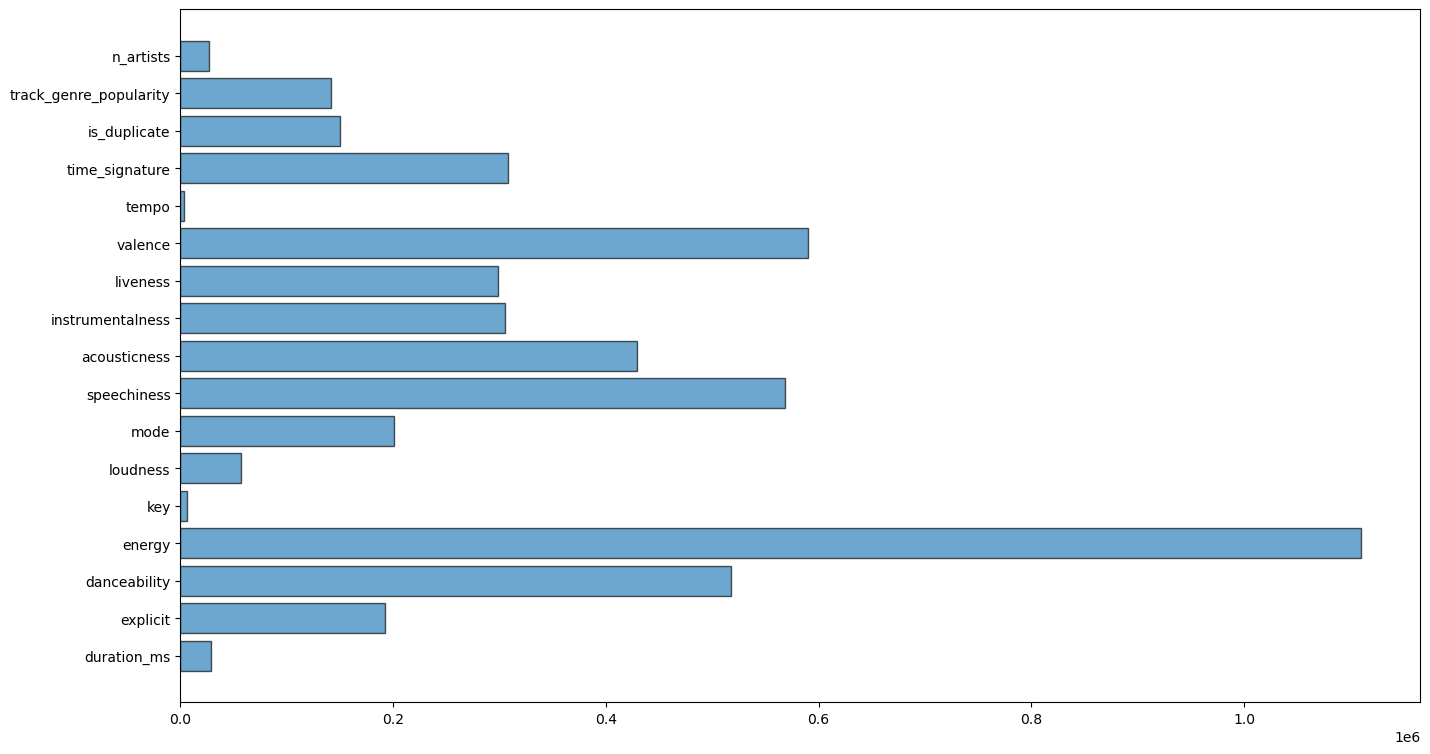

In [58]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(n_jobs=4)
linreg.fit(X_pop_train, y_pop_train)

plt.barh(X_pop_train.columns, np.abs(linreg.coef_), edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

Let's analyse the quality of the model. Reference: [sklearn article](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

In [59]:
from numpy.typing import ArrayLike
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss

def regression_report(y_true: ArrayLike, y_pred: ArrayLike) -> None:
    """Makes a report for regression, similar to sklearn.metrics.classification_report.

    Args:
        y_true (ArrayLike): The true values.
        y_pred (ArrayLike): The predicted values.
    """
    print(f'MSE:\t\t{mean_squared_error(y_true, y_pred)}')
    print(f'MAE:\t\t{mean_absolute_error(y_true, y_pred)}')
    print(f'R2:\t\t{r2_score(y_true, y_pred)}')
    print(f'MPL:\t\t{mean_pinball_loss(y_true, y_pred)}')

In [60]:
y_pop_pred = linreg.predict(X_pop_test)
regression_report(y_pop_test, y_pop_pred)

MSE:		257.0370909793755
MAE:		12.233184251318862
R2:		0.31565758815824263
MPL:		6.116592125659431


The higher the R2, the better. But the higher the MSE, MAE and MPL, the worse. 

The MAE (mean absolute error) tells us how good the model is: it is on average 12 popularity points off, which is not bad.

Let's help the model: we know that popularity is an integer between 0 and 100. If we use np.round to make the prediction an integer and np.clip to clip it, we get a better result:

In [61]:
y_pop_pred_rounded = np.round(np.clip(y_pop_pred, 0, 100))
regression_report(y_pop_test, y_pop_pred_rounded)

MSE:		253.3731490015361
MAE:		12.14930875576037
R2:		0.32541256507775673
MPL:		6.074654377880185


Let's try the same on the updated data:

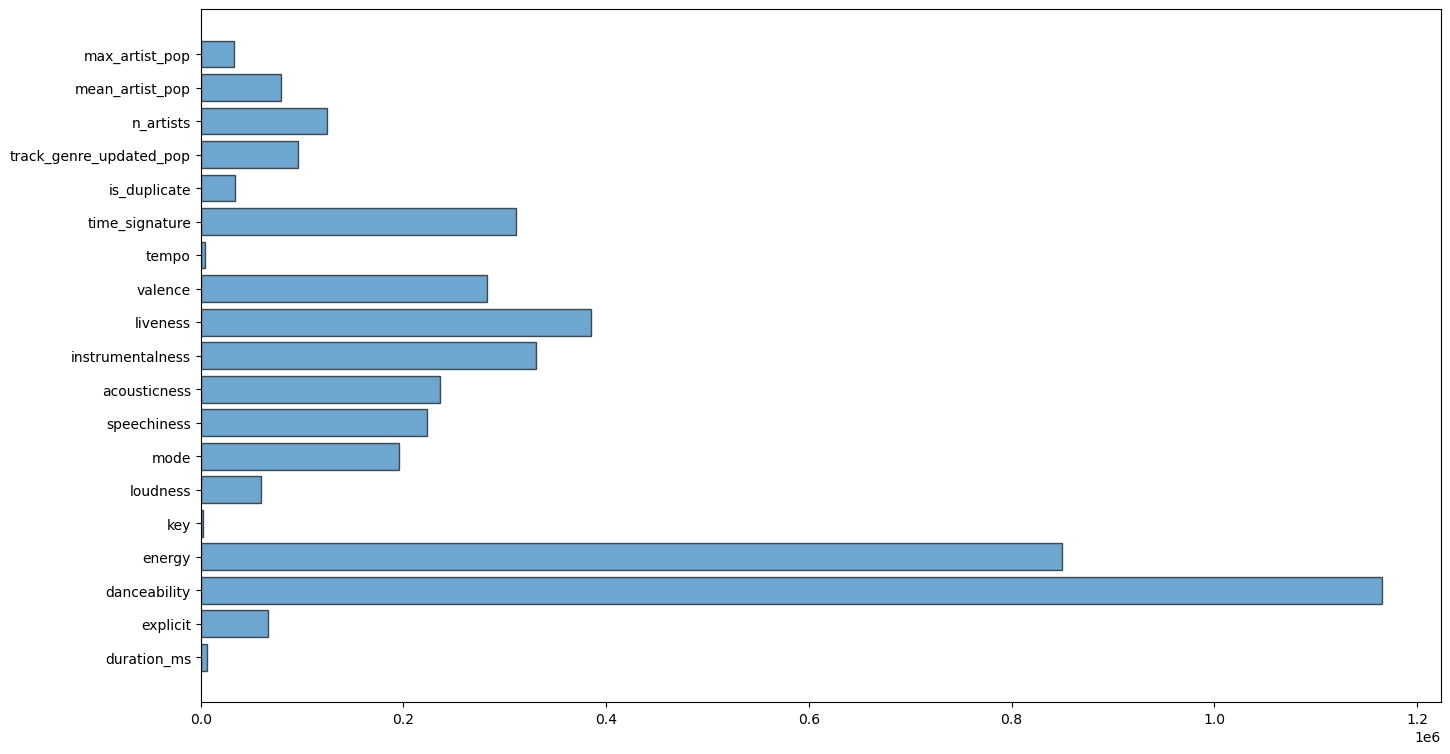

In [62]:
linreg = LinearRegression(n_jobs=4)
linreg.fit(X_upd_train, y_upd_train)

plt.barh(X_upd_train.columns, np.abs(linreg.coef_), edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

In [63]:
y_upd_pred = linreg.predict(X_upd_test)
y_upd_pred_rounded = np.round(np.clip(y_upd_pred, 0, 100))
regression_report(y_upd_test, y_upd_pred_rounded)

MSE:		308.7136712749616
MAE:		13.764976958525345
R2:		0.2605941992101404
MPL:		6.882488479262673


Now the model performs worse. This might be because linear models are bad at dealing with too many features, but we'll know for sure only once we test another model and see if the same problem arises.

So according to the linear regression weights:
- The most important features are **energy** and **danceability**;
- The least important features are key, tempo and duration_ms.

Otherwise the results are unreliable. Also, the model itself didn't work too well, so we should look at other models.

## 4.3 Catboost feature importance

Most models measure the importance of the features themselves. Since gradient boosting is the best model for ML on tabular data, the result we'll get should be one of the most reliable so far. We'll use catboost for gradient boosting (in my experience, catboost has the best initial parameters, and since we're not going to optimise the parameters in cross-validation, it's a good idea to use this model).

As gradient boosting is based on tree models, normalisation won't affect performance, so we can just use the normalised data we just used for linear regression.

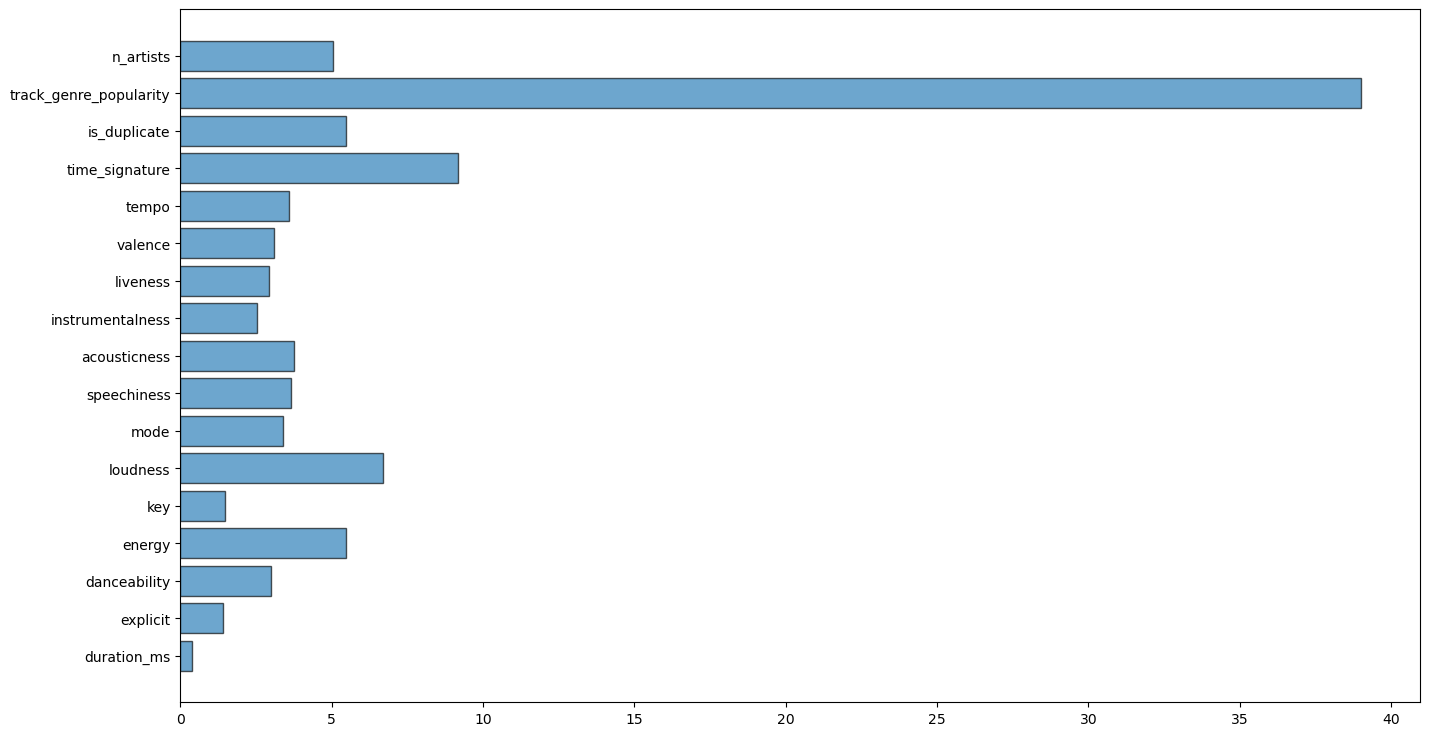

In [64]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose=False)
cat.fit(X_pop_train, y_pop_train)

plt.barh(X_pop_train.columns, np.abs(cat.feature_importances_), edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

In [65]:
y_pop_pred = cat.predict(X_pop_test)
y_pop_pred_rounded = np.round(np.clip(y_pop_pred, 0, 100))
regression_report(y_pop_test, y_pop_pred_rounded)

MSE:		214.45013824884794
MAE:		10.315453149001536
R2:		0.4290422278363295
MPL:		5.157726574500768


The model works much better (10 points off on average) and the importance of the features seems to be very different from what we saw in the linear model!

What happens when we do the same on the updated data?

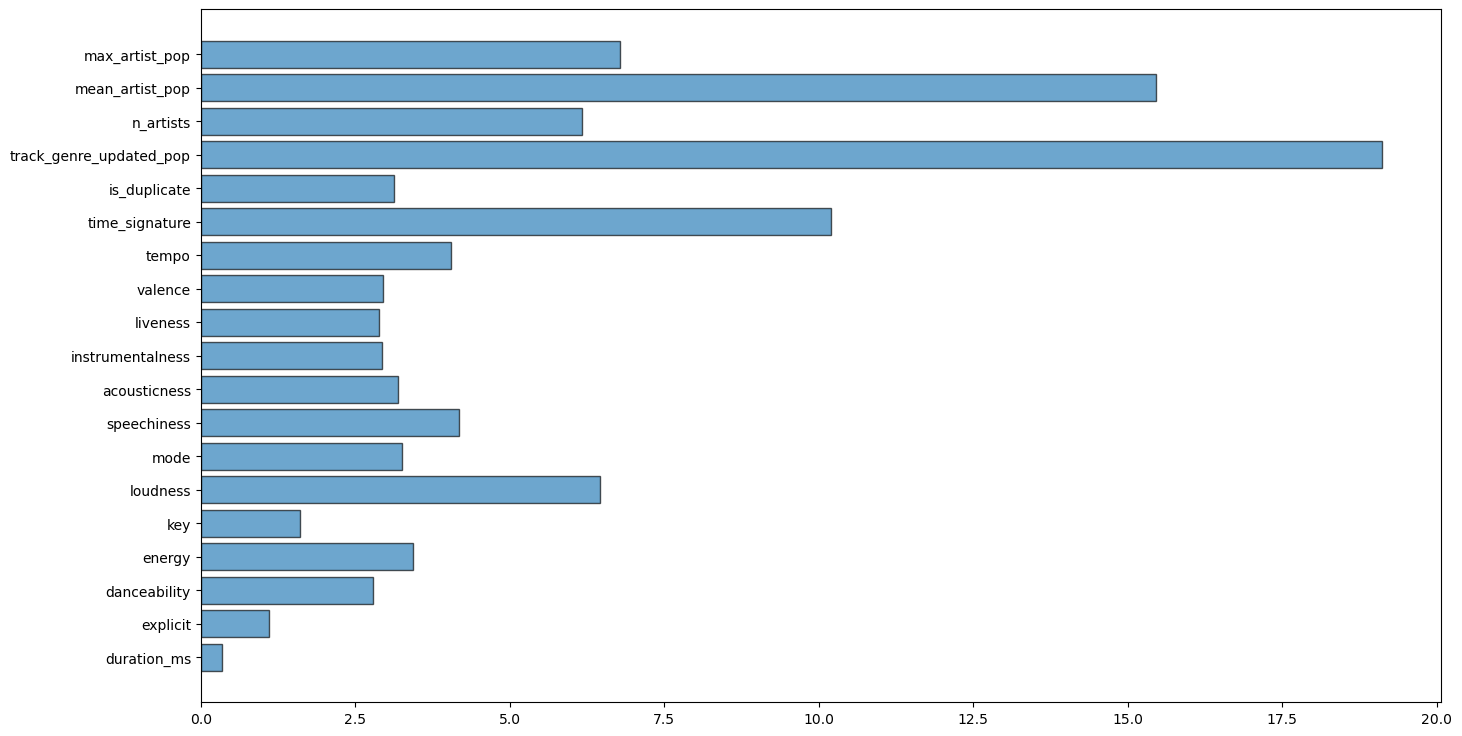

In [66]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_upd_train, y_upd_train)

plt.barh(X_upd_train.columns, np.abs(cat.feature_importances_), edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

In [67]:
y_upd_pred = cat.predict(X_upd_test)
y_upd_pred_rounded = np.round(np.clip(y_upd_pred, 0, 100))
regression_report(y_upd_test, y_upd_pred_rounded)

MSE:		261.76669738863285
MAE:		11.986543778801844
R2:		0.37303776116099374
MPL:		5.993271889400922


Once again, the model based on the updated data performs worse. This is not because the features we have added have caused the model to perform this way, but because the target has also changed. This could be the problem with using a 2 year old dataset to predict the current data, even though we have updated the only data that should have changed.

These values (cat.feature_importances_) test tells us that
- Track Genre and Artist Popularity are indeed the most important features, which is also proven by the correlation test and the f-test;
- Interestingly, n_artists, time_signature and loudness are really important, which is only proved by the linear regression test, but not supported by the statistical tests;
- Key, explicitness and duration_ms are the least important, which is close to the results obtained by other tests.

## 4.4 Features Rating

To conclude the results of the tests performed, we'd like to compile the final rating of the features.

(As we have seen, if the feature is present in both the X_pop and X_upd, then it scored similarly in tests performed for both datasets. So, we'll only refer to the results of the test on the updated data.)

The features:

In [68]:
features = X_upd.columns.values
features

array(['duration_ms', 'explicit', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'is_duplicate', 'track_genre_updated_pop',
       'n_artists', 'mean_artist_pop', 'max_artist_pop'], dtype=object)

Let's go through the tests again (since we now know more or less objectively how good the model is thanks to the train-test split, we can simply train the models on the whole dataset):

- Correlation test (the higher the absolute value of correlation, the better the feature):

In [69]:
scores_corr = np.corrcoef(np.float64(pd.concat((X_upd, y_upd), axis=1)), rowvar=False)[-1][:-1]
scores_corr = np.abs(scores_corr)
scores_corr

array([0.02570783, 0.020587  , 0.04843123, 0.02135384, 0.00054511,
       0.10247878, 0.00786889, 0.08643716, 0.04044044, 0.19219084,
       0.02216502, 0.05244821, 0.00144701, 0.03124115, 0.06664611,
       0.52079423, 0.00989546, 0.50361131, 0.47064427])

- f-test (the higher the F-statistic, the better the feature; no normalization, as it is not normally used for the test):

In [70]:
scores_f, _ = f_regression(X_upd, y_upd)
scores_f

array([5.38117414e+01, 3.45008162e+01, 1.91306548e+02, 3.71200749e+01,
       2.41783383e-02, 8.63598604e+02, 5.03863330e+00, 6.12515206e+02,
       1.33291221e+02, 3.12082764e+03, 3.99952616e+01, 2.24448469e+02,
       1.70372944e-01, 7.94944798e+01, 3.63029470e+02, 3.02829949e+04,
       7.96844340e+00, 2.76498294e+04, 2.31520401e+04])

- Linear regression weights (the higher the absolute value of the weight, the better the feature):

In [71]:
from sklearn.preprocessing import normalize

linreg = LinearRegression()
X_upd_norm = normalize(X_upd)
linreg.fit(X_upd_norm, y_upd)

scores_linreg = np.abs(linreg.coef_)
scores_linreg

array([   6248.42584153,   58987.61086537, 1215332.037219  ,
        940789.08595329,    4318.33940343,   60260.931022  ,
        186078.06950983,  114583.52614326,  318959.3637611 ,
        288291.223323  ,  411433.48206013,  179393.59169564,
          4503.03645164,  303682.72263699,   30020.469518  ,
         97501.00037887,   96617.77259781,   75592.67809108,
         28762.30188559])

- Catboost feature importances:

In [72]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_upd, y_upd)
scores_cat = cat.feature_importances_
scores_cat

array([ 3.90677808,  1.14614853,  3.41360781,  2.53418153,  0.90534871,
        3.53311484,  0.16326166,  3.1211616 ,  3.5576425 ,  2.748309  ,
        2.47837874,  2.58013111,  2.43408177,  0.29308321,  2.29547095,
       31.68691098,  1.81890118, 20.58715257, 10.79633522])

Let's visualize the scores. Because the methods are completely different, the values will be of different scales. Thus, we'll also apply normalization.

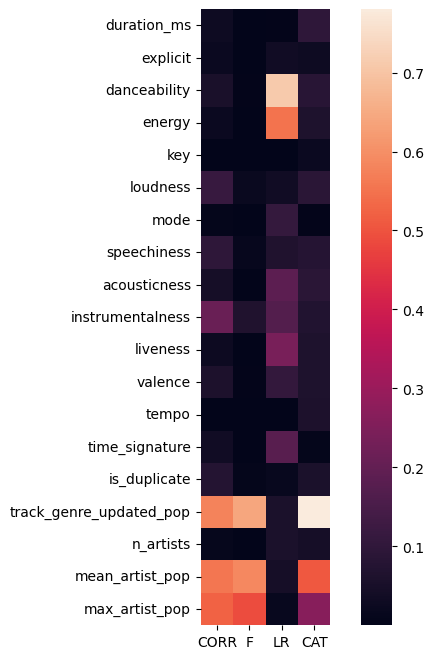

In [73]:
# put together in dataframe
scores = pd.DataFrame(data = np.concatenate((
    scores_corr.reshape(1,-1),
    scores_f.reshape(1,-1),
    scores_linreg.reshape(1,-1),
    scores_cat.reshape(1,-1)
), axis=0), columns = features)

# normalize & heatmap
sns.heatmap(normalize(scores).T, yticklabels=scores.columns, xticklabels=['CORR', 'F', 'LR', 'CAT'])
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches((8,8))
plt.show()

We can make the rating by taking a mean of the normalized scores for each feature and taking that as a total score and base our rating on that:

In [74]:
total_score = np.mean(normalize(scores).T, axis=1)
feature_score = list(zip(list(features), list(total_score)))
feature_score

[('duration_ms', 0.03236150135929309),
 ('explicit', 0.021563357681060966),
 ('danceability', 0.21317841160446463),
 ('energy', 0.15930030518669375),
 ('key', 0.006355023419644034),
 ('loudness', 0.06350125367205842),
 ('mode', 0.030424588890926512),
 ('speechiness', 0.06314032040111804),
 ('acousticness', 0.0804471418145873),
 ('instrumentalness', 0.12880873420211775),
 ('liveness', 0.08177596222329916),
 ('valence', 0.057825162639556005),
 ('tempo', 0.016041825802629982),
 ('time_signature', 0.055288062725697945),
 ('is_duplicate', 0.038890721984040894),
 ('track_genre_updated_pop', 0.5138257145006953),
 ('n_artists', 0.028107587959199078),
 ('mean_artist_pop', 0.4236017641527543),
 ('max_artist_pop', 0.32354573676403625)]

In [75]:
top_features = [feat_score[0] for feat_score in sorted(feature_score, key=lambda x: x[1])]
top_scores = sorted(total_score)

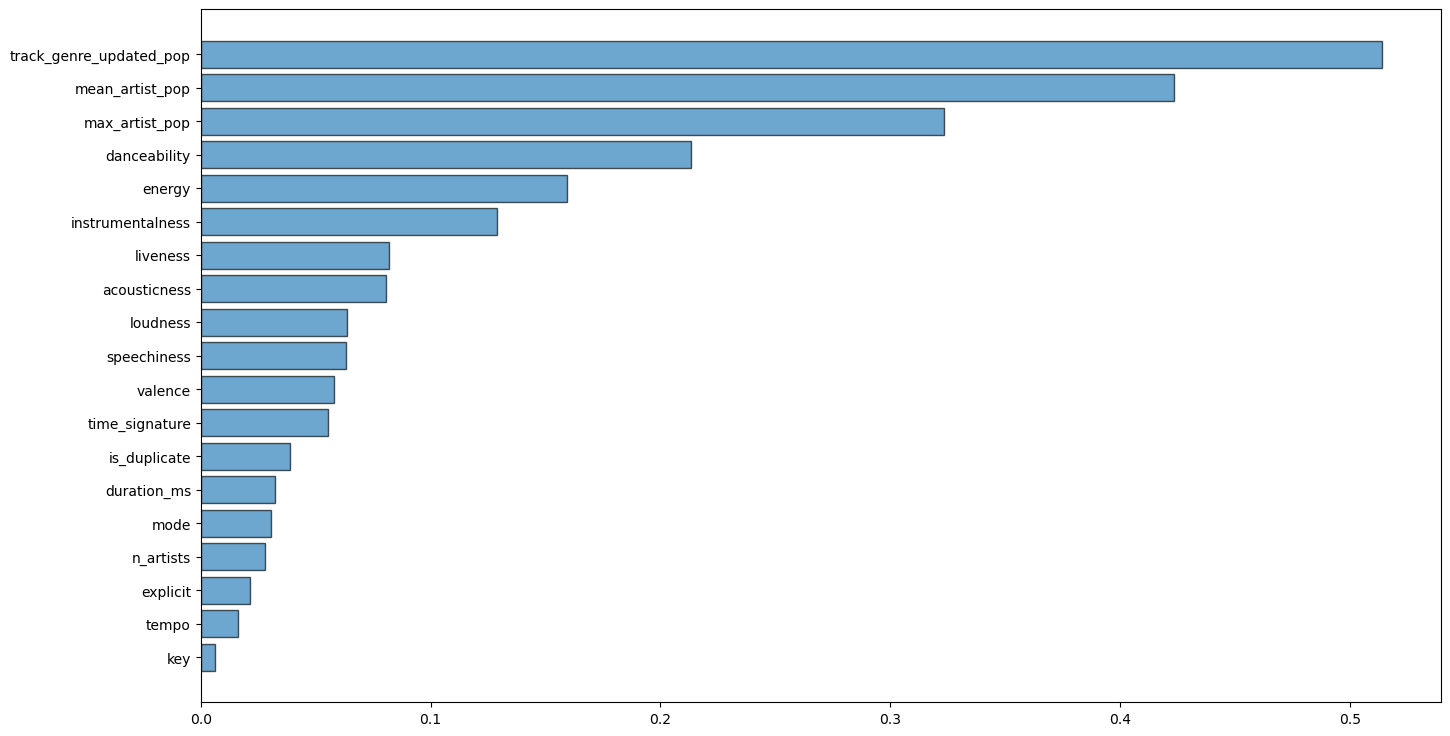

In [76]:
plt.barh(top_features, top_scores, edgecolor='k', alpha=0.65)
plt.gcf().set_size_inches(16, 9)
plt.show()

# 5. Conclusion

Several conclusions can be drawn:
1. It is very difficult to make a good prediction of a track's popularity based on its metadata and audio features alone.
2. If we limit ourselves to classical ML methods, the most useful features can be generated by target encoding, although its effectiveness is doubtful due to the possibility of target leakage.
3. Individual audio features don't carry much information, but in combination with average genre and artist popularity they can be used for decent popularity predictions (MAE < 12).
4. Audio features that describe the song more 'subjectively' are more informative than those that are objective (e.g. energy vs tempo).

The result has several limitations:
1. The main data we used (mainly the selection of tracks) was collected 2 years ago, although we are trying to predict current data. If we had better data (possibly without duplicates, which would have made the project much easier), the results might have been more cheerful.
2. Spotify is only one of many music streaming services (e.g. Apple Music, Yandex Music, SoundCloud, etc.), so the results may only be specific to Spotify (especially considering that each service uses its own unique recommendation algorithms).
3. Also, Spotify is not even used in all countries, nor are streaming services the only way to enjoy music.

# 6. Extra

Now that we have an algorithm for predicting track popularity, it would be interesting to test it on inference. So I've created a game on Streamlit to play against the computer and test how good a human would be at predicting the popularity of a track.

I wish I could make an option where you could type in the name of your favourite song and play against the computer in predicting its popularity, but that would either reveal my API key, or require everyone playing to have a Spotify account and risk revealing the API key (this is due to the way Streamlit works, but also because extra data would be required to download via the Spotify API).

Instead, we will build an unfair catboost model, trained on the same data, that will play against the human player :)

The game: